In [37]:
jakob_file_to_norm = "/Users/constantin/workspace/data/jakob/investigate_normalization/DA-F05.3_PL01-POL-LT_DA-SER1.23_DA4O11.01resLibC_-first-pass_v03Sc_ion_LibPGQVal1perc.tsv.diann_fragion_isotopes.aq_reformat.tsv"
unaffected_protein_file = "/Users/constantin/workspace/data/jakob/investigate_normalization/unaffected_proteins.tsv"


In [23]:
#create a pandas dataframe with 100 rows and 10.000 columns
import pandas as pd
import numpy as np
import time

num_samples = 10000
num_proteins = 1000
df = pd.DataFrame(np.random.default_rng().normal(loc=100,scale= 3,size=(num_proteins, num_samples)), columns=list(range(num_samples)))
#create array of random integers of size num_samples
scaling_factors = np.random.default_rng().integers(low=10, high=1000, size=num_samples)

#add scaling factors to columns
for i in range(num_samples):
    df[i] = df[i] + scaling_factors[i]

mask = np.random.choice([0, 1], size=(num_proteins, num_samples), p=[0.5, 0.5])
#apply mask to df
df = df.mask(mask == 1)
display(df)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,298.953117,NaN,NaN,NaN,NaN,447.016383,829.136764,499.216000,948.409732,NaN,...,NaN,NaN,509.643564,NaN,411.818630,956.695548,1083.617117,NaN,168.805519,NaN
1,NaN,430.832490,444.757242,493.154061,963.002381,NaN,829.149163,501.781497,NaN,791.948433,...,950.180239,NaN,NaN,NaN,409.761247,964.363598,1085.592304,NaN,159.792253,NaN
2,NaN,426.127125,NaN,500.757671,NaN,449.979932,NaN,505.130356,NaN,793.252276,...,950.468532,1070.764609,504.994650,130.917075,406.550100,NaN,1080.399879,130.336065,162.139382,306.010998
3,NaN,NaN,442.738320,495.959246,NaN,446.041013,832.069958,NaN,NaN,792.033050,...,NaN,NaN,NaN,NaN,NaN,953.214681,NaN,124.871761,NaN,NaN
4,297.803400,426.889805,NaN,NaN,NaN,445.831784,NaN,NaN,NaN,789.798007,...,951.869511,NaN,NaN,NaN,405.224633,956.555792,NaN,126.967170,NaN,306.068090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,298.531075,NaN,441.587963,NaN,NaN,NaN,NaN,495.396366,NaN,NaN,...,949.884029,1071.278265,NaN,129.878923,NaN,951.364617,NaN,130.607095,167.096047,299.442378
996,300.040853,NaN,447.524714,499.456590,NaN,NaN,NaN,NaN,NaN,788.270419,...,950.498841,1067.555999,506.606290,131.691700,407.817498,953.651958,1085.140042,NaN,162.439883,NaN
997,297.215291,NaN,445.147081,NaN,962.364133,442.684640,830.253859,498.646172,NaN,789.393339,...,952.667640,NaN,NaN,131.191659,409.032627,960.203982,NaN,132.794650,NaN,309.359370
998,NaN,428.322285,442.572555,498.017128,963.637694,446.585574,NaN,496.630864,NaN,NaN,...,952.566435,NaN,NaN,130.625162,413.499578,NaN,1086.937798,127.653557,NaN,308.758235


In [24]:
import directlfq.normalization

class NormalizationManagerSamplesOnSelectedProteinsDirectInput(directlfq.normalization.NormalizationManagerSamplesOnSelectedProteins):
    def __init__(self, complete_dataframe, num_samples_quadratic, selected_protein_groups):
        complete_dataframe = complete_dataframe.T #the samples to shift are in each row, therefore the df needs to be transposed
        super().__init__(complete_dataframe, num_samples_quadratic)
        self.normalization_function = self._normalization_function
        self._selected_protein_groups = selected_protein_groups
        self._run_normalization()
        self.complete_dataframe = complete_dataframe.T

    

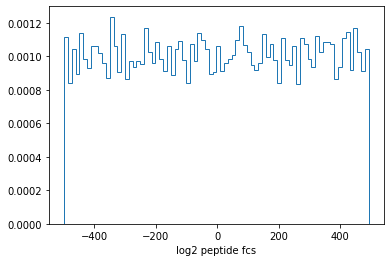

to few values for normalization without missing values. Including missing values


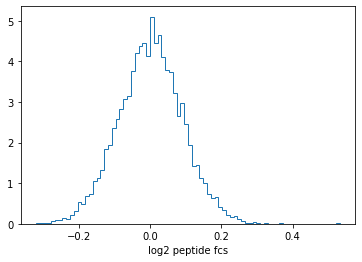

to few values for normalization without missing values. Including missing values
to few values for normalization without missing values. Including missing values


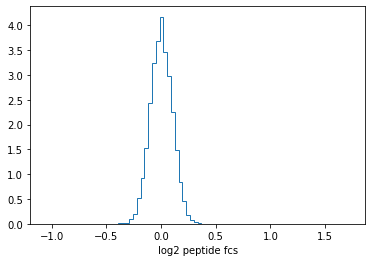

In [33]:
import directlfq.normalization
import directlfq.utils as lfq_utils

def visualize_normalization_steps(df_to_normalize):
    lfq_utils.plot_relative_to_median_fcs(df_to_normalize)
    input_df_normalized = directlfq.normalization.NormalizationManagerSamples(df_to_normalize, num_samples_quadratic=50).complete_dataframe
    lfq_utils.plot_relative_to_median_fcs(input_df_normalized)

    #randomly select 100 items from a list
    import random
    selected_protein_groups = random.sample(list(df_to_normalize.index), 100)
    input_df_normalized_selected_proteins = NormalizationManagerSamplesOnSelectedProteinsDirectInput(df_to_normalize, num_samples_quadratic=30, selected_protein_groups=selected_protein_groups).complete_dataframe
    lfq_utils.plot_relative_to_median_fcs(input_df_normalized_selected_proteins)


visualize_normalization_steps(df)

In [38]:
import pandas as pd
import numpy as np

jakob_df = pd.read_csv(jakob_file_to_norm, sep="\t")



In [39]:
jakob_df_adapted = jakob_df.copy().set_index(["protein", "ion"])
numeric_cols = jakob_df_adapted.select_dtypes(include=np.number).columns

jakob_df_adapted = jakob_df_adapted[numeric_cols]

jakob_df_adapted = jakob_df_adapted.replace(0, np.nan)
jakob_df_adapted = np.log2(jakob_df_adapted)
display(jakob_df_adapted)


20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_POS-A01_S1-A1_1_5782.d  \
protein    ion                                                                                                                        
A0A024R6I7 SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          15.032373                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          14.493355                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          14.574487                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          13.884237                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          13.792963                      
...                                                                                                          ...                      
Q9Y6Y8     SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_4_                                                   9.843954                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_5_                                                   8.224040                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_6_                                                   8.930764                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_7_                                                   8.413662                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_MS1ISOTOPES_2_                                             14.623053                      

                                                               20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_POS-A02_S1-A2_1_5783.d  \
protein    ion                                                                                                                        
A0A024R6I7 SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          11.717745                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          11.110555                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          10.991600                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          10.534371                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          10.479841                      
...                                                                                                          ...                      
Q9Y6Y8     SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_4_                                                   8.550785                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_5_                                                   7.761578                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_6_                                                   7.491893                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_7_                                                   9.264471                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_MS1ISOTOPES_2_                                             14.647992                      

                                                               20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_POS-A03_S1-A3_1_5784.d  \
protein    ion                                                                                                                        
A0A024R6I7 SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          14.045393                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          13.570401                      
           

In [40]:
display(jakob_df_adapted)


20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_POS-A01_S1-A1_1_5782.d  \
protein    ion                                                                                                                        
A0A024R6I7 SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          15.032373                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          14.493355                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          14.574487                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          13.884237                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          13.792963                      
...                                                                                                          ...                      
Q9Y6Y8     SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_4_                                                   9.843954                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_5_                                                   8.224040                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_6_                                                   8.930764                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_7_                                                   8.413662                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_MS1ISOTOPES_2_                                             14.623053                      

                                                               20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_POS-A02_S1-A2_1_5783.d  \
protein    ion                                                                                                                        
A0A024R6I7 SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          11.717745                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          11.110555                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          10.991600                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          10.534371                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          10.479841                      
...                                                                                                          ...                      
Q9Y6Y8     SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_4_                                                   8.550785                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_5_                                                   7.761578                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_6_                                                   7.491893                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_FRGION_7_                                                   9.264471                      
           SEQ_QLHFQEK_MOD_QLHFQEK_CHARGE_2_MS1ISOTOPES_2_                                             14.647992                      

                                                               20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_POS-A03_S1-A3_1_5784.d  \
protein    ion                                                                                                                        
A0A024R6I7 SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          14.045393                      
           SEQ_DTEEEDFHVDQATTVK_MOD_DTEEEDFHVDQATTVK_CHARG...                                          13.570401                      
           

In [ ]:

def visualize_normalization_steps_selected_subset(df_to_normalize, selected_proteins_file):
    lfq_utils.plot_relative_to_median_fcs(df_to_normalize)
    input_df_normalized = directlfq.normalization.NormalizationManagerSamples(df_to_normalize, num_samples_quadratic=50).complete_dataframe
    lfq_utils.plot_relative_to_median_fcs(input_df_normalized)

    #randomly select 100 items from a list
    input_df_normalized_selected_proteins = directlfq.normalization.NormalizationManagerSamplesOnSelectedProteins(df_to_normalize, num_samples_quadratic=50,selected_proteins_file=selected_proteins_file).complete_dataframe
    lfq_utils.plot_relative_to_median_fcs(input_df_normalized_selected_proteins)


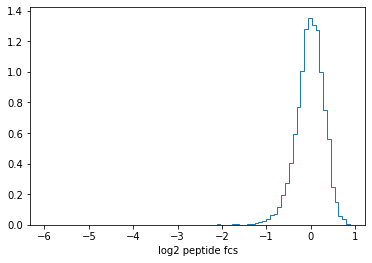

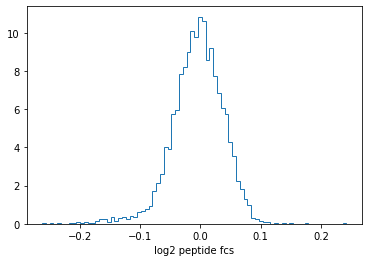

to few values for normalization without missing values. Including missing values


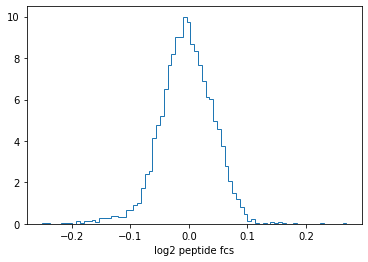

In [36]:
visualize_normalization_steps(jakob_df)